/tmp/ipykernel_47339/4186580777.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True, header=None, names=column_names)
/tmp/ipykernel_47339/4186580777.py:86: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis = df.groupby('binned')[target_name].agg(['count', 'mean']).reset_index()
/tmp/ipykernel_47339/4186580777.py:86: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis = df.groupby('binned')[target_name].agg(['count', 'mean']).reset_index()
/tmp/ipykernel_47339/

status   0
credit_history   2
purpose   4
savings   0
employment   2
personal_status   2
other_debtors   0
property   0
other_installment_plans   2
housing   1
job   2
telephone   1
foreign_worker   0
duration   24          5.759528055258091
amount   5000          1.0
installment_rate   4          1.0
residence_since   2          1.0
age   35          9.574468085106384
existing_credits   1          1.0
num_dependents   1          5
RESULTADOS PARA LA NUEVA INSTANCIA
Probabilidad de default: 0.610
Categoría de riesgo: Alto
Score total: 4.53

SCORES POR CATEGORÍA (5 C's)
Carácter: 4.54
Capacidad: 4.43
Capital: 5.00
Colateral: 5.00
Condiciones: 3.67

SCORES INDIVIDUALES POR VARIABLE
Variable		Valor		Score	Categoría
------------------------------------------------------------
Estado cuenta       	A11       	5.00	Carácter
Duración            	24        	5.76	Carácter
Historial crédito   	A32       	5.00	Carácter
Propósito           	A43       	5.00	Carácter
Monto               	5000      	1

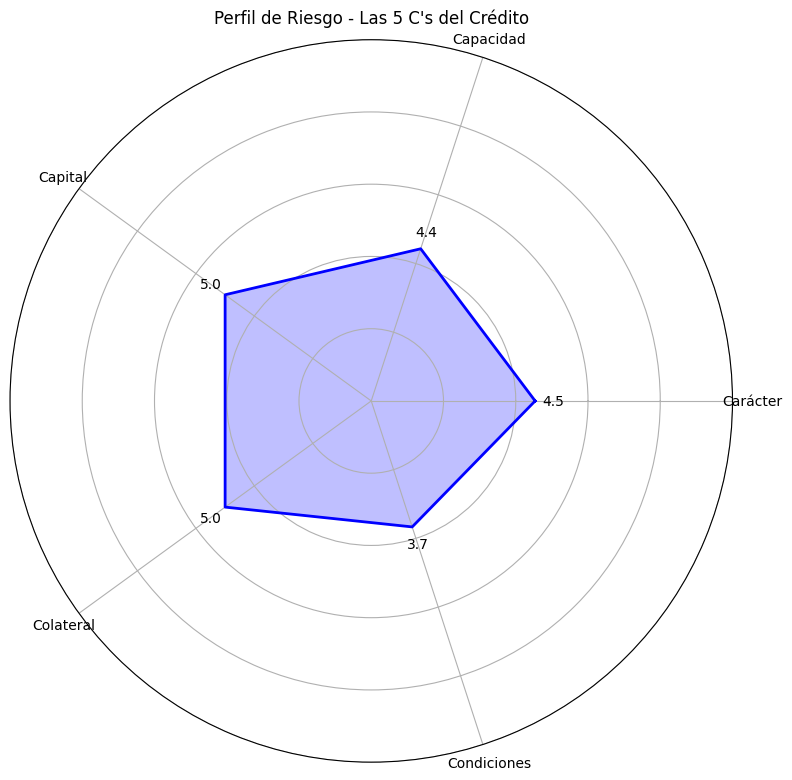


INTERPRETACIÓN DE RESULTADOS
Carácter: Refleja la confiabilidad del solicitante (historial crediticio, estabilidad)
Capacidad: Evalúa la habilidad para pagar (ingresos, gastos, empleo)
Capital: Mide los recursos propios (ahorros, inversiones, patrimonio)
Colateral: Considera las garantías ofrecidas (propiedades, activos)
Condiciones: Analiza el contexto del crédito (tasa, plazo, condiciones económicas)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib

# =============================================================================
# 1. PREPROCESAMIENTO Y ANÁLISIS DE TODAS LAS VARIABLES
# =============================================================================

# Cargar datos
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
column_names = ['status', 'duration', 'credit_history', 'purpose', 'amount',
                'savings', 'employment', 'installment_rate', 'personal_status',
                'other_debtors', 'residence_since', 'property', 'age',
                'other_installment_plans', 'housing', 'existing_credits',
                'job', 'num_dependents', 'telephone', 'foreign_worker', 'target']

df = pd.read_csv(url, delim_whitespace=True, header=None, names=column_names)
df['target'] = df['target'].replace({1: 0, 2: 1})  # 0 = Buen crédito, 1 = Default

# Codificar variables categóricas
label_encoders = {}
X_encoded = df.drop('target', axis=1).copy()

for column in X_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_encoded[column] = le.fit_transform(X_encoded[column])
    label_encoders[column] = le
    joblib.dump(le, f'label_encoder_{column}.pkl')

y = df['target']

# Escalar características numéricas
numeric_columns = ['duration', 'amount', 'installment_rate', 'residence_since', 
                   'age', 'existing_credits', 'num_dependents']
scaler = StandardScaler()
X_encoded[numeric_columns] = scaler.fit_transform(X_encoded[numeric_columns])
joblib.dump(scaler, 'scaler.pkl')

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

# Entrenar modelo
model = RandomForestClassifier(n_estimators=100, random_state=42, 
                              class_weight='balanced')
model.fit(X_train, y_train)
joblib.dump(model, 'credit_scoring_model.pkl')

# Obtener importancia de características
feature_importances = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# =============================================================================
# 2. CREAR SISTEMA DE SCORING PARA TODAS LAS VARIABLES
# =============================================================================

# Función para calcular scores para variables categóricas
def calculate_categorical_scores(df, column_name, target_name='target'):
    analysis = df.groupby(column_name)[target_name].agg(['count', 'mean']).reset_index()
    analysis.columns = [column_name, 'count', 'default_rate']
    analysis = analysis.sort_values('default_rate')
    
    max_rate = analysis['default_rate'].max()
    min_rate = analysis['default_rate'].min()
    
    if max_rate == min_rate:
        analysis['score'] = 5
    else:
        analysis['score'] = 10 - ((analysis['default_rate'] - min_rate) / 
                                 (max_rate - min_rate) * 9)
    
    score_map = dict(zip(analysis[column_name], analysis['score']))
    return score_map

# Función para calcular scores para variables numéricas
def calculate_numeric_scores(df, column_name, target_name='target', bins=5):
    df['binned'] = pd.qcut(df[column_name], bins, duplicates='drop')
    
    analysis = df.groupby('binned')[target_name].agg(['count', 'mean']).reset_index()
    analysis.columns = ['binned', 'count', 'default_rate']
    analysis = analysis.sort_values('default_rate')
    
    max_rate = analysis['default_rate'].max()
    min_rate = analysis['default_rate'].min()
    
    if max_rate == min_rate:
        analysis['score'] = 5
    else:
        analysis['score'] = 10 - ((analysis['default_rate'] - min_rate) / 
                                 (max_rate - min_rate) * 9)
    
    intervals = []
    scores = []
    for _, row in analysis.iterrows():
        intervals.append(row['binned'])
        scores.append(row['score'])
    
    return intervals, scores

# Calcular scores para todas las variables categóricas
categorical_columns = ['status', 'credit_history', 'purpose', 'savings', 
                      'employment', 'personal_status', 'other_debtors', 
                      'property', 'other_installment_plans', 'housing', 
                      'job', 'telephone', 'foreign_worker']

score_mappings = {}
for col in categorical_columns:
    score_mappings[col] = calculate_categorical_scores(df, col)

# Calcular scores para todas las variables numéricas
numeric_columns = ['duration', 'amount', 'installment_rate', 'residence_since', 
                  'age', 'existing_credits', 'num_dependents']

numeric_score_params = {}
for col in numeric_columns:
    intervals, scores = calculate_numeric_scores(df, col)
    numeric_score_params[col] = {
        'intervals': intervals,
        'scores': scores
    }

# Guardar los mapeos de scores
joblib.dump(score_mappings, 'categorical_score_mappings.pkl')
joblib.dump(numeric_score_params, 'numeric_score_params.pkl')

# =============================================================================
# 3. MAPEO A LAS 5 C's Y SISTEMA DE SCORING COMPLETO
# =============================================================================

# Mapeo de variables a las 5 C's
c5_mapping = {
    'Carácter': ['status', 'credit_history', 'duration', 'purpose', 
                'personal_status', 'residence_since', 'foreign_worker'],
    'Capacidad': ['employment', 'installment_rate', 'age', 'existing_credits', 
                    'job', 'num_dependents'],
    'Capital': ['savings', 'property'],
    'Colateral': ['other_debtors', 'housing', 'property'],
    'Condiciones': ['amount', 'other_installment_plans', 'telephone']
}

# Función para mapear valores numéricos a scores
def map_numeric_value_to_score(value, intervals, scores):
    for i, interval in enumerate(intervals):
        if value in interval:
            return scores[i]
    return 5

# Función para calcular el score de una instancia
def calculate_instance_score(instance, score_mappings, numeric_score_params, c5_mapping):
    scores = {category: [] for category in c5_mapping.keys()}
    individual_scores = {}
    
    # Procesar variables categóricas
    for col, mapping in score_mappings.items():
        value = instance[col]
        print(col, " ", value)
        if value in mapping:
            score = mapping[value]
        else:
            score = 5  # Valor por defecto si no se encuentra
        individual_scores[col] = score
        # Asignar a la categoría correspondiente
        for category, features in c5_mapping.items():
            if col in features:
                scores[category].append(score)
                break
    
    # Procesar variables numéricas
    for col, params in numeric_score_params.items():
        value = instance[col]
        score = map_numeric_value_to_score(value, params['intervals'], params['scores'])
        individual_scores[col] = score
        # Asignar a la categoría correspondiente
        print(col, " ", value, "        ", score)
        for category, features in c5_mapping.items():
            if col in features:
                scores[category].append(score)
                break
    
    # Calcular promedio por categoría
    final_scores = {}
    for category, values in scores.items():
        if values:
            final_scores[category] = sum(values) / len(values)
        else:
            final_scores[category] = 5
    
    total_score = sum(final_scores.values()) / len(final_scores)
    
    return final_scores, total_score, individual_scores

# =============================================================================
# 4. SISTEMA PARA NUEVAS INSTANCIAS
# =============================================================================

def predict_new_instance(new_data, model_path='credit_scoring_model.pkl', 
                        scaler_path='scaler.pkl', 
                        categorical_mappings_path='categorical_score_mappings.pkl',
                        numeric_params_path='numeric_score_params.pkl'):
    
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    categorical_mappings = joblib.load(categorical_mappings_path)
    numeric_params = joblib.load(numeric_params_path)
    
    # Preprocesar la nueva instancia
    processed_data = new_data.copy()
    
    # Codificar variables categóricas
    for col in categorical_mappings.keys():
        if col in processed_data:
            le = joblib.load(f'label_encoder_{col}.pkl')
            try:
                processed_data[col] = le.transform([processed_data[col]])[0]
            except ValueError:
                processed_data[col] = -1  # Valor para categorías no vistas
    
    # Escalar variables numéricas
    numeric_columns = ['duration', 'amount', 'installment_rate', 'residence_since', 
                      'age', 'existing_credits', 'num_dependents']
    for col in numeric_columns:
        if col in processed_data:
            try:
                processed_data[col] = scaler.transform([[processed_data[col]]])[0][0]
            except:
                pass
    
    # Predecir probabilidad de default
    features = [processed_data[col] for col in model.feature_names_in_]
    default_probability = model.predict_proba([features])[0][1]
    
    # Calcular scores para las 5 C's
    c_scores, total_score, individual_scores = calculate_instance_score(processed_data, 
                                                                       categorical_mappings, 
                                                                       numeric_params, 
                                                                       c5_mapping)
    
    return {
        'default_probability': default_probability,
        '5c_scores': c_scores,
        'total_score': total_score,
        'individual_scores': individual_scores,
        'risk_category': 'Alto' if default_probability > 0.5 else 'Bajo'
    }

# =============================================================================
# 5. VISUALIZACIÓN DE RESULTADOS
# =============================================================================

def plot_5c_scores(scores):
    categories = list(scores.keys())
    values = list(scores.values())
    
    categories += categories[:1]
    values += values[:1]
    
    angles = [n / float(len(categories)-1) * 2 * np.pi for n in range(len(categories))]
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.plot(angles, values, color='blue', linewidth=2)
    ax.fill(angles, values, color='blue', alpha=0.25)
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories[:-1])
    ax.set_ylim(0, 10)
    
    for angle, value, category in zip(angles[:-1], values[:-1], categories[:-1]):
        ax.text(angle, value+0.5, f'{value:.1f}', ha='center', va='center')
    
    plt.title('Perfil de Riesgo - Las 5 C\'s del Crédito')
    plt.tight_layout()
    plt.show()

# =============================================================================
# EJECUCIÓN CON NUEVA INSTANCIA
# =============================================================================

# Definir nueva instancia
new_instance = {
    'status': 'A11',
    'duration': 24,
    'credit_history': 'A32',
    'purpose': 'A43',
    'amount': 5000,
    'savings': 'A61',
    'employment': 'A73',
    'installment_rate': 4,
    'personal_status': 'A93',
    'other_debtors': 'A101',
    'residence_since': 2,
    'property': 'A121',
    'age': 35,
    'other_installment_plans': 'A143',
    'housing': 'A152',
    'existing_credits': 1,
    'job': 'A173',
    'num_dependents': 1,
    'telephone': 'A192',
    'foreign_worker': 'A201'
}

# Predecir
result = predict_new_instance(new_instance)

# Mostrar resultados detallados
print("=" * 60)
print("RESULTADOS PARA LA NUEVA INSTANCIA")
print("=" * 60)
print(f"Probabilidad de default: {result['default_probability']:.3f}")
print(f"Categoría de riesgo: {result['risk_category']}")
print(f"Score total: {result['total_score']:.2f}")

print("\n" + "=" * 60)
print("SCORES POR CATEGORÍA (5 C's)")
print("=" * 60)
for category, score in result['5c_scores'].items():
    print(f"{category}: {score:.2f}")

print("\n" + "=" * 60)
print("SCORES INDIVIDUALES POR VARIABLE")
print("=" * 60)
print("Variable\t\tValor\t\tScore\tCategoría")
print("-" * 60)

# Mapeo de nombres de variables a descripciones más legibles
variable_descriptions = {
    'status': 'Estado cuenta',
    'duration': 'Duración',
    'credit_history': 'Historial crédito',
    'purpose': 'Propósito',
    'amount': 'Monto',
    'savings': 'Ahorros',
    'employment': 'Empleo',
    'installment_rate': 'Tasa pago',
    'personal_status': 'Estado personal',
    'other_debtors': 'Otros deudores',
    'residence_since': 'Residencia desde',
    'property': 'Propiedades',
    'age': 'Edad',
    'other_installment_plans': 'Otros planes pago',
    'housing': 'Vivienda',
    'existing_credits': 'Créditos existentes',
    'job': 'Trabajo',
    'num_dependents': 'Dependientes',
    'telephone': 'Teléfono',
    'foreign_worker': 'Trabajador extranjero'
}

# Mostrar scores individuales para todas las variables
for var_name in variable_descriptions.keys():
    if var_name in result['individual_scores']:
        score = result['individual_scores'][var_name]
        value = new_instance[var_name]
        desc = variable_descriptions[var_name]
        
        # Encontrar la categoría correspondiente
        category = None
        for cat, features in c5_mapping.items():
            if var_name in features:
                category = cat
                break
        
        print(f"{desc:<20}\t{value:<10}\t{score:.2f}\t{category}")
    else:
        print(f"{var_name} no encontrada en los scores individuales")

# Visualizar scores de las 5 C's
plot_5c_scores(result['5c_scores'])

print("\n" + "=" * 60)
print("INTERPRETACIÓN DE RESULTADOS")
print("=" * 60)
print("Carácter: Refleja la confiabilidad del solicitante (historial crediticio, estabilidad)")
print("Capacidad: Evalúa la habilidad para pagar (ingresos, gastos, empleo)")
print("Capital: Mide los recursos propios (ahorros, inversiones, patrimonio)")
print("Colateral: Considera las garantías ofrecidas (propiedades, activos)")
print("Condiciones: Analiza el contexto del crédito (tasa, plazo, condiciones económicas)")

In [2]:
# Mostrar scores individuales para todas las variables
for var_name in variable_descriptions.keys():
    if var_name in result['individual_scores']:
        score = result['individual_scores'][var_name]
        value = new_instance[var_name]
        desc = variable_descriptions[var_name]
        
        # Encontrar la categoría correspondiente
        category = None
        for cat, features in c5_mapping.items():
            if var_name in features:
                category = cat
                break
        
        print(f"{desc:<20}\t{value:<10}\t{score:.2f}\t{category}")
    else:
        print(f"{var_name} no encontrada en los scores individuales")


Estado cuenta       	A11       	5.00	Carácter
Duración            	24        	5.76	Carácter
Historial crédito   	A32       	5.00	Carácter
Propósito           	A43       	5.00	Carácter
Monto               	5000      	1.00	Condiciones
Ahorros             	A61       	5.00	Capital
Empleo              	A73       	5.00	Capacidad
Tasa pago           	4         	1.00	Capacidad
Estado personal     	A93       	5.00	Carácter
Otros deudores      	A101      	5.00	Colateral
Residencia desde    	2         	1.00	Carácter
Propiedades         	A121      	5.00	Capital
Edad                	35        	9.57	Capacidad
Otros planes pago   	A143      	5.00	Condiciones
Vivienda            	A152      	5.00	Colateral
Créditos existentes 	1         	1.00	Capacidad
Trabajo             	A173      	5.00	Capacidad
Dependientes        	1         	5.00	Capacidad
Teléfono            	A192      	5.00	Condiciones
Trabajador extranjero	A201      	5.00	Carácter


In [3]:
df['status'].unique()

array(['A11', 'A12', 'A14', 'A13'], dtype=object)